# Notebook 1 - Simulation

In this notebook we use `harissa` to simulate a basic repressilator network with 3 genes (1 ⇥ 2 ⇥ 3 ⇥ 1).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys; sys.path += ['../']
from harissa import NetworkModel
%config InlineBackend.figure_formats = ['svg']

## Model definition

We start by initializing the dynamical model and set the network interactions.

In [2]:
model = NetworkModel(3)
# Basal gene activities
model.basal[1] = 5
model.basal[2] = 5
model.basal[3] = 5
# Inhibitions in cycle
model.inter[1,2] = -10
model.inter[2,3] = -10
model.inter[3,1] = -10

## First simulation

We can now simulate and plot a trajectory for one single cell. Some critical parameters of the dynamical model are the degradation rates $d_0$ and $d_1$ which characterize the ‘responsiveness’ of mRNA and protein levels. Note that the `harissa.simulation` module is not based on time discretization and always returns exact stochastic simulations: the resulting continuous-time trajectories are simply extracted at user-specified time points.

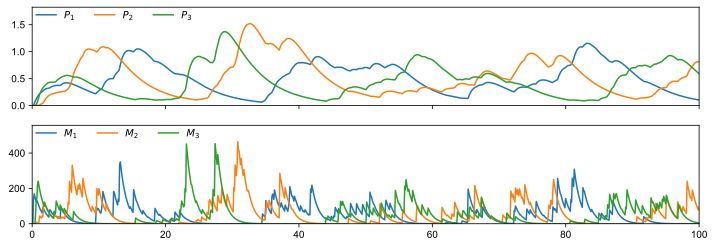

In [3]:
# Degradation rates (per unit of time)
model.d[0] = 1 # mRNA
model.d[1] = 0.2 # protein
# Set required time points
time = np.linspace(0,100,1000)
# Compute exact simulation
sim = model.simulate(time)
# Basic plotting function
def basic_plot(sim):
    fig = plt.figure(figsize=(12,4))
    gs = gridspec.GridSpec(2,1)
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[1,0])
    # Plot proteins
    for i in range(3):
        ax1.plot(sim.t, sim.p[:,i], label=f'$P_{{{i+1}}}$')
        ax1.set_xlim(sim.t[0], sim.t[-1])
        ax1.set_ylim(0, np.max([1.2*np.max(sim.p), 1]))
        ax1.tick_params(axis='x', labelbottom=False)
        ax1.legend(loc='upper left', ncol=4, borderaxespad=0, frameon=False)
    # Plot mRNA
    for i in range(3):
        ax2.plot(sim.t, sim.m[:,i], label=f'$M_{{{i+1}}}$')
        ax2.set_xlim(sim.t[0], sim.t[-1])
        ax2.set_ylim(0, 1.2*np.max(sim.m))
        ax2.legend(loc='upper left', ncol=4, borderaxespad=0, frameon=False)
# Plot the simulation
basic_plot(sim)

Here the ratio $d_0/d_1 \approx 5$ is biologically relevant. Note that despite the strong level of stochasticity, a robust periodic pattern is already emerging.

## Simulation with more stable proteins

More stable proteins – with respect to mRNA – will lead to less ‘intrinsic noise’ in the system. Here we increase the mRNA degradation rates instead, which is equivalent to a zoom-out regarding the time scale. Note that mRNA and protein scales are normalized so the overall levels do not depend on degradation rates (but the *dynamics* does).

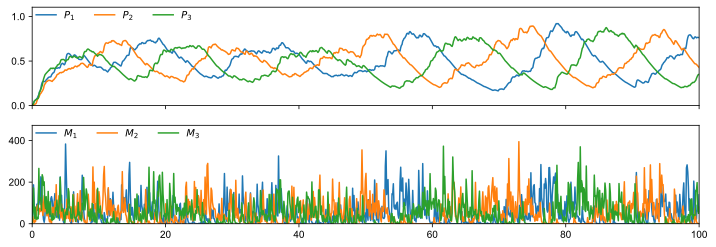

In [4]:
# mRNA degradation rate
model.d[0] = 10
# Compute exact simulation
sim = model.simulate(time)
# Plot the simulation
basic_plot(sim)

The emerging periodic pattern is now more visible.

## Even more stable proteins

Let us try with even more stable proteins ($d_0/d_1 \approx 250$).

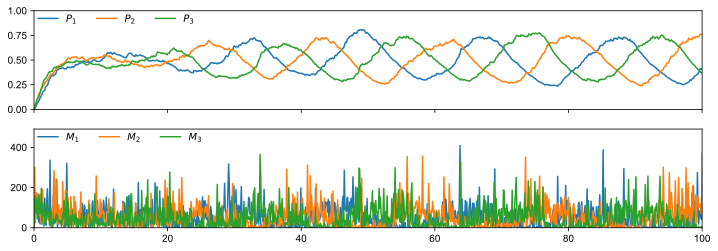

In [5]:
# The simulation may take longer as we zoom-out
model.d[0] = 50
# Compute exact simulation
sim = model.simulate(time)
# Plot the simulation
basic_plot(sim)

The system is now approaching a ‘slow-fast’ limit where proteins follow deterministic dynamics. Note that mRNA levels start to follow a quasi-steady-state (QSS) distribution and become *independent conditionally on protein levels* such that $M_i(t) \sim \mathrm{Gamma}(k_{\mathrm{on},i}(P(t))/d_{0,i},b_i)$ for $i=1,2,3$.

## Deterministic limit

At the limit $d_0/d_1 \to \infty$, the stochastic model converges towards a nonlinear ODE system involving only proteins. Note that in this deterministic regime, the initial protein levels need to be perturbed so as not to stay in a trivial manifold.

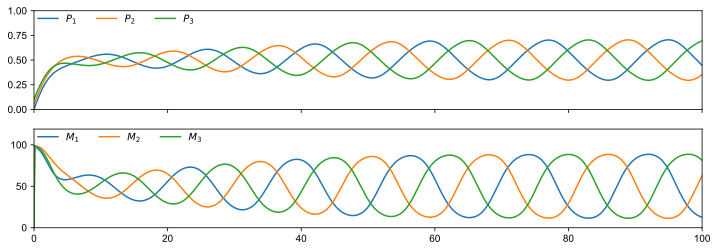

In [6]:
# Deterministic model (slow-fast limit)
sim = model.simulate_ode(time, P0=[0,0,0.05,0.1])
# Plot the simulation
basic_plot(sim)

Regarding mRNA levels, the `simulate_ode` method only returns the *mean* of the quasi-steady-state distribution conditionally on protein levels (the true limit model would consist in sampling $M_i(t) \sim \mathrm{Gamma}(k_{\mathrm{on},i}(P(t))/d_{0,i},b_i$) independently for every $t > 0$).

## Final remark

It is of course possible to set specific mRNA and protein degradation rates for each gene.

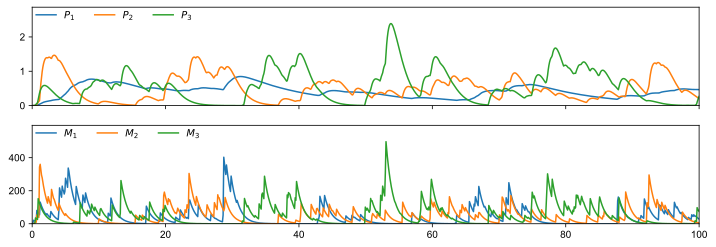

In [ ]:
# Ignore d[0][0] and d[1][0] (gene 0 = stimulus)
model.d[0][1:] = [1, 1, 1]
model.d[1][1:] = [0.1, 0.8, 0.85]
# Stochastic model
sim = model.simulate(time)
basic_plot(sim)
# Deterministic model
sim = model.simulate_ode(time)
basic_plot(sim)

...Degradation rates are crucial parameters of the dynamical model.